In [ ]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter
from transformers import logging
logging.set_verbosity_error()

import warnings
warnings.filterwarnings("ignore")

In [ ]:
'''
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)
'''

"\n# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).\ntry:\n    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\n    print('Running on TPU ', tpu.master())\nexcept ValueError:\n    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.\n    strategy = tf.distribute.get_strategy()\n\nprint('Number of replicas:', strategy.num_replicas_in_sync)\n"

In [ ]:
'''
# Detect hardware, return appropriate distribution strategy
try:
    # GPU detection in Colab
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # If there is a GPU, use GPU
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('Running on GPU')
    else:
        # If there is no GPU, default to CPU
        strategy = tf.distribute.get_strategy()
        print('Running on CPU')
except RuntimeError as e:
    print(e)
    # If an error occurs during GPU detection, default to CPU
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')

print('Number of replicas:', strategy.num_replicas_in_sync)
'''

'\n# Detect hardware, return appropriate distribution strategy\ntry:\n    # GPU detection in Colab\n    gpus = tf.config.experimental.list_physical_devices(\'GPU\')\n    if gpus:\n        # If there is a GPU, use GPU\n        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")\n        print(\'Running on GPU\')\n    else:\n        # If there is no GPU, default to CPU\n        strategy = tf.distribute.get_strategy()\n        print(\'Running on CPU\')\nexcept RuntimeError as e:\n    print(e)\n    # If an error occurs during GPU detection, default to CPU\n    strategy = tf.distribute.get_strategy()\n    print(\'Running on CPU\')\n\nprint(\'Number of replicas:\', strategy.num_replicas_in_sync)\n'

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Colab)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
    print('Running on CPU or GPU')

print('Number of replicas:', strategy.num_replicas_in_sync)


Running on TPU  grpc://10.26.0.74:8470
Number of replicas: 8


## Prepare dataset

1.   Remove punctuation symbols and double white spaces
2.   Lemmatization
3.   Remove stop words (see spacy.lang.en.stop_words.STOP_WORDS)
4.   TD-IDF

In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 4

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
df = pd.read_csv('/content/tfidf_dataset.csv')
df.head()

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean raids box office ocean crime caper seque...,entertainment


In [ ]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['category']].to_numpy().reshape(-1)

## Dataset analysis
As you can see in the following plot, the samples are not balanced. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

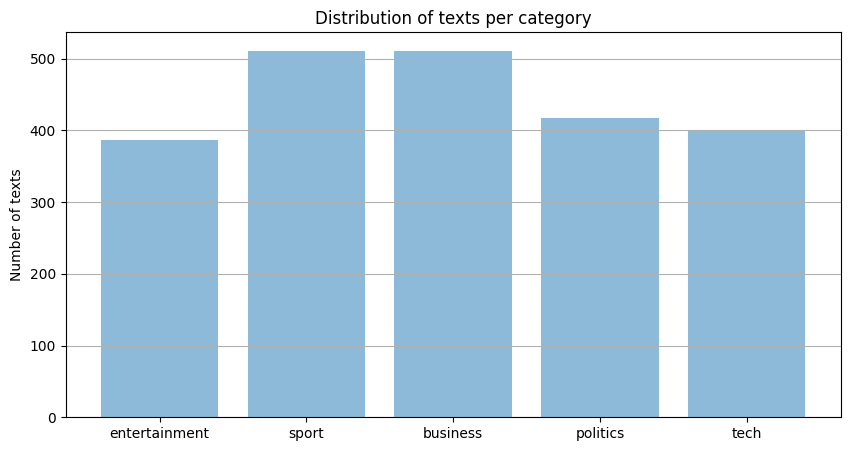

Counter({'sport': 511, 'business': 510, 'politics': 417, 'tech': 401, 'entertainment': 386})


In [ ]:
categories = df[['category']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(df, split_char=' '):
    categories = df['category'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['category']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['category'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In these histograms and stats, we can see that almost all texts contain  500
  or less words. Also, we can see that the average length is very different depending on the category.

Please, note that the tokenization process may split words into several parts, so lengths could increase (or decrease too). This is only an orientative result.

In [ ]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
entertainment,"[165, 375, 174, 108, 167, 189, 130, 230, 115, ...",168.585492,118.648402
sport,"[86, 86, 92, 72, 71, 68, 703, 257, 226, 71, 71...",159.681018,92.709783
business,"[90, 82, 105, 169, 229, 321, 100, 85, 82, 127,...",172.876471,65.119283
politics,"[115, 297, 289, 116, 208, 235, 231, 183, 113, ...",215.347722,128.812873
tech,"[194, 117, 274, 135, 223, 170, 222, 165, 168, ...",241.835411,103.570666


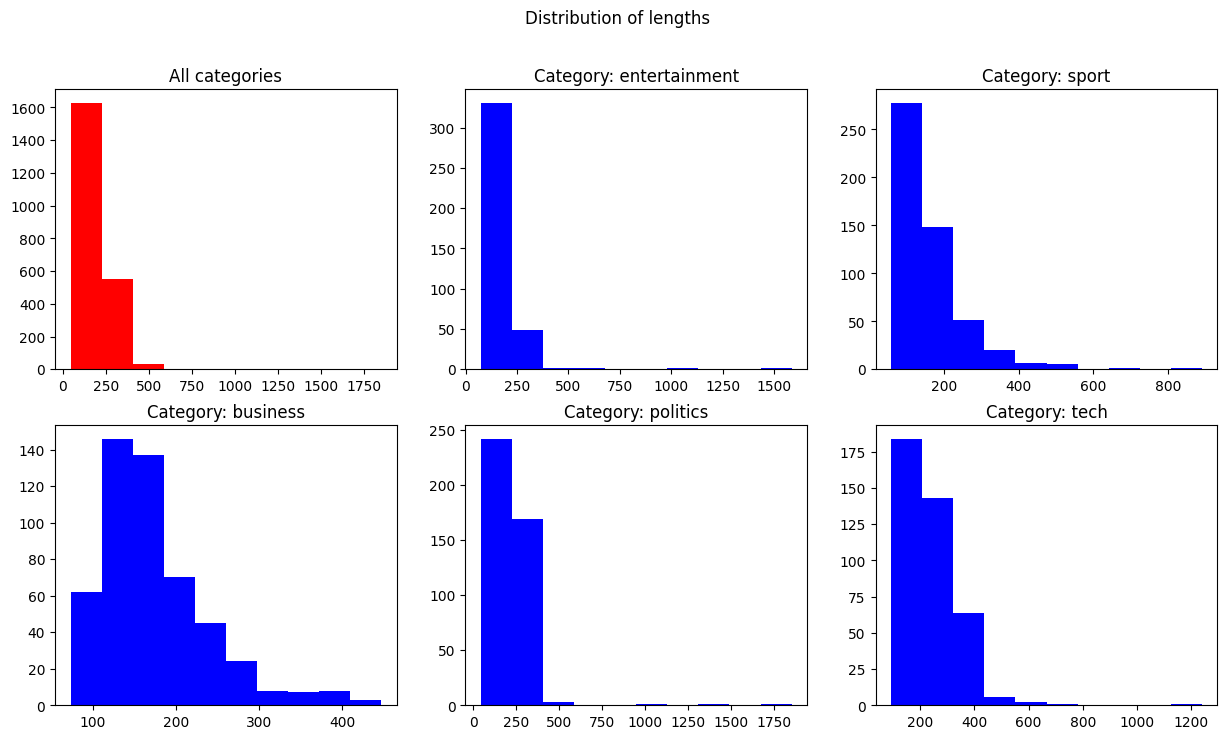

In [ ]:
display_lengths_histograms(df_stats)


In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['category'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 2225
Number of categories: 5
Done!


## Tokenize & encode
I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus we must truncate the tokenized texts. In my case, I truncate to 256 tokens, but you can put a higher value in the variable MAX_LEN.

See https://huggingface.co/roberta-base

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'entertainment', 1: 'sport', 2: 'business', 3: 'politics', 4: 'tech'}

In [ ]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create RoBERTa model

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 256)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                              

## Train model
This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section.

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/4


25/25 [==============================] - 137s 2s/step - loss: 0.5425 - accuracy: 0.8015 - val_loss: 0.1267 - val_accuracy: 0.9581
Epoch 2/4
25/25 [==============================] - 5s 205ms/step - loss: 0.0803 - accuracy: 0.9750 - val_loss: 0.0910 - val_accuracy: 0.9760
Epoch 3/4
25/25 [==============================] - 6s 234ms/step - loss: 0.0351 - accuracy: 0.9891 - val_loss: 0.0839 - val_accuracy: 0.9701
Epoch 4/4
25/25 [==============================] - 5s 204ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0592 - val_accuracy: 0.9850


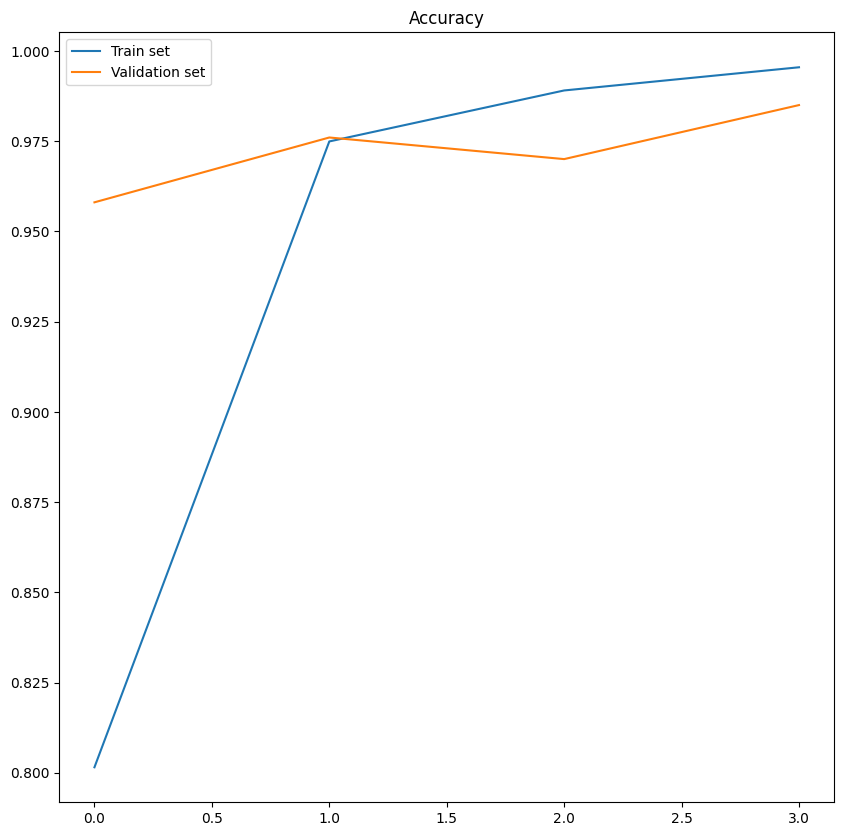

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

## Evaluation
In a confusion matrix, we can see how many categories are classified c

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 98.50%


21/21 [==============================] - 1s 33ms/step


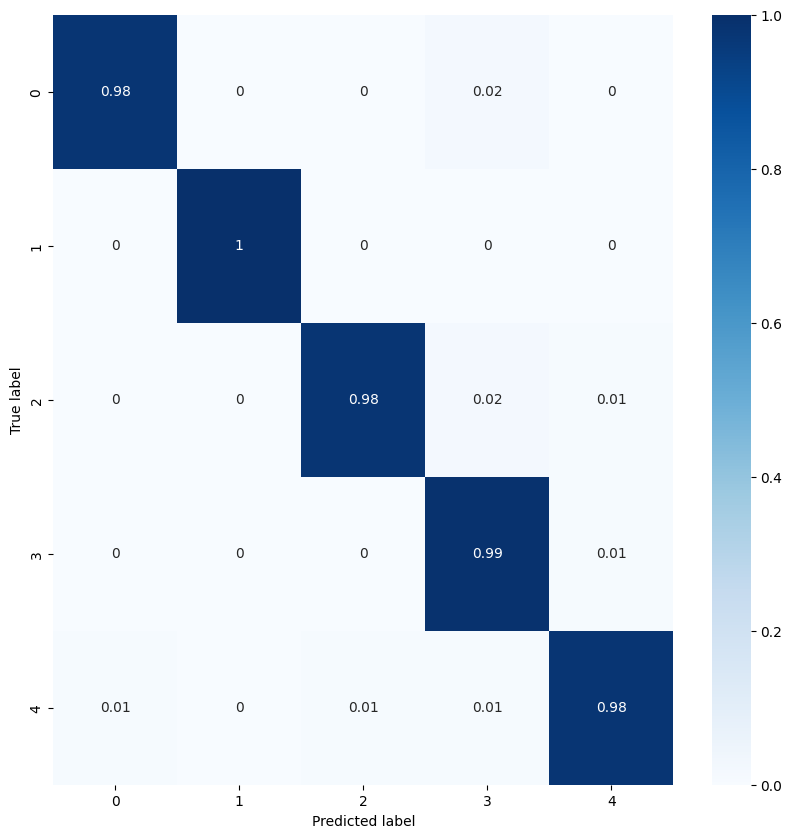

In [ ]:
plot_confusion_matrix(X_test, y_test, model)


In [ ]:

# Save the entire model to a HDF5 file
model.save('my_model.h5')


In [ ]:
'''
from google.colab import files
files.download('my_model.h5')
'''

"\nfrom google.colab import files\nfiles.download('my_model.h5')\n"

## Convert the saved h5 model to ONNX format

  ONNX (Open Neural Network Exchange) is a format for representing deep learning models in a standardized way.

1. Interoperability: ONNX enables interoperability between different deep
learning frameworks. If you have a model trained in one framework (e.g., TensorFlow, PyTorch), you can convert it to ONNX format and then deploy it using another framework. This can be beneficial if a specific framework is known for better performance or has optimizations that suit a particular deployment environment.

2. Hardware Acceleration: ONNX supports integration with hardware accelerators like GPUs, TPUs, and FPGAs. Many runtime environments and inference engines that support ONNX can take advantage of specialized hardware to accelerate computations, reducing latency during model inference.

3. Model Quantization: ONNX provides support for quantization, a technique to reduce the precision of model weights and activations. Quantized models typically require fewer computational resources, leading to faster inference with lower latency. Some inference engines that support ONNX can take advantage of quantized models.

4. Model Optimization: ONNX supports various optimization techniques, and some deployment environments leverage these optimizations to reduce the computational complexity of the model. This can result in faster inference and lower latency.

5. Runtime Environments: ONNX models can be executed using multiple runtime environments. Some of these runtimes are optimized for low latency, making them suitable for real-time applications. Choosing a runtime environment that aligns with low-latency requirements can contribute to improved performance.

In [ ]:
from transformers import TFRobertaModel

@keras.utils.register_keras_serializable(package='transformers')
class TFRobertaModel(TFRobertaModel):
    pass

In [ ]:
#Load The saved keras model

!pip uninstall tensorflow
!pip install tensorflow --upgrade
!python -m pip uninstall keras --yes
!pip install keras==2.15.0



Found existing installation: tensorflow 2.15.0.post1
Uninstalling tensorflow-2.15.0.post1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.post1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0.post1
  Using cached tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)


Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)


RecursionError: ignored

In [ ]:
import tf2onnx.convert
import onnx
#from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model
import transformers
from tensorflow import keras


loaded_keras_model = load_model('/content/my_model.h5', custom_objects={"TFRobertaModel": transformers.TFRobertaModel})

In [ ]:
onnx_model, _ = tf2onnx.convert.from_keras(loaded_keras_model)
onnx.save(onnx_model, 'onnx_model.onnx')

# Using the command line to convert h5 to ONNX
```
import tensorflow as tf
from tensorflow import keras
import transformers

model = keras.models.load_model("my_h5_model.h5", custom_objects= {{"TFRobertaModel": transformers.TFRobertaModel})
tf.saved_model.save(model, "tmp_model")
```

**Then convert it using tf2onnx.**

`python -m tf2onnx.convert --saved-model tmp_model --output model.onnx`